## Imports and Helper functions

In [3]:
import seaborn as sns
import matplotlib
import matplotlib.colors
import numpy as np
import mediapy as media
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import PIL
import io

import matplotlib.patches

from IPython.display import HTML as html_print

2025-12-09 19:43:02.428166: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765327382.501976 2315003 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765327382.525600 2315003 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1765327382.700521 2315003 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765327382.700540 2315003 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765327382.700543 2315003 computation_placer.cc:177] computation placer alr

In [4]:
def segmentation_to_rgb(seg, palette=None, num_objects=None, bg_color=(0, 0, 0)):
  if num_objects is None:
    num_objects = np.max(seg)  # assume consecutive numbering
  num_objects += 1  # background
  if palette is None:
    palette = [bg_color] + sns.color_palette('hls', num_objects-1)

  seg_img = np.zeros((seg.shape[0], seg.shape[1], 3), dtype=np.float32)
  for i in range(num_objects):
    seg_img[np.nonzero(seg[:, :, 0] == i)] = palette[i]
  return seg_img

def depth_to_rgb(depth, colormap=matplotlib.cm.viridis_r, sqrt=True):
  cmap = np.array(colormap.colors)
  if sqrt:
    d = np.round(np.sqrt((depth[..., 0] / 65535).clip(0, 1.)) * 255).astype(np.uint8)
  else:
    d = np.round(depth[..., 0] // 256).astype(np.uint8)
  return cmap[d]

def flow_to_rgb(vec, flow_mag_range=None, white_bg=False):
  height, width = vec.shape[:2]
  scaling = 50. / (height**2 + width**2)**0.5
  direction = (np.arctan2(vec[..., 0], vec[..., 1]) + np.pi) / (2 * np.pi)
  norm = np.linalg.norm(vec, axis=-1)
  if flow_mag_range is None:
    flow_mag_range = norm.min(), norm.max()
  magnitude = np.clip((norm - flow_mag_range[0]) * scaling, 0., 1.)
  if white_bg == True:
    value = np.ones_like(direction)
    hsv = np.stack([direction, magnitude, saturation], axis=-1)
  else:
    saturation = np.ones_like(direction)
    hsv = np.stack([direction, saturation , magnitude], axis=-1)
  rgb = matplotlib.colors.hsv_to_rgb(hsv)
  return rgb

def plot_bboxes(sample, palette=None, linewidth=1):
  resolution = sample["video"].shape[-3:-1]

  bboxes = sample["instances"]["bboxes"]
  bbox_frames = sample["instances"]["bbox_frames"]
  num_objects = bboxes.shape[0]
  if palette is None:
      palette = sns.color_palette('hls', num_objects)
  images = []
  for t, rgb in enumerate(sample["video"]):
    fig, ax = plt.subplots(figsize=(resolution[0]/100, resolution[1]/100), dpi=132.5)
    ax.axis("off")
    ax.imshow(rgb)
    for k in range(num_objects):
      if t in bbox_frames[k]:
        idx = np.nonzero(bbox_frames[k] == t)[0][0]

        miny, minx, maxy, maxx = bboxes[k][idx]
        miny = max(1, miny*resolution[0])
        minx = max(1, minx*resolution[1])
        maxy = min(resolution[0]-1, maxy*resolution[0])
        maxx = min(resolution[1]-1, maxx*resolution[1])
        rect = matplotlib.patches.Rectangle([minx, miny], maxx-minx, maxy-miny,
                                            linewidth=linewidth, edgecolor=palette[k],
                                            facecolor='none')
        ax.add_patch(rect)


    for k in range(num_objects):
      x, y = sample["instances"]["image_positions"][k, t] * resolution
      if np.all(1 < y < resolution[0]-1) and np.all(1 < x < resolution[1]-1):
        ax.scatter(x, y, marker="X", s=5, color=palette[k])
    buf = io.BytesIO()
    fig.savefig(buf, format = "png", bbox_inches = 'tight', pad_inches = 0, dpi=132.5)
    plt.close(fig)
    buf.seek(0)
    img = PIL.Image.open(buf)
    images.append(np.array(img)[..., :3])
  return images

def getsize(arr): 
  if isinstance(arr, np.ndarray):
    return arr.nbytes
  elif isinstance(arr, dict):
    return sum([getsize(v) for v in arr.values()])
  elif isinstance(arr, list):
    return sum([getsize(v) for v in arr])
  else:
    return sys.getsizeof(arr)

def print_instance_ids(sample, ds_info, palette=None):
  if palette is None:
    palette = sns.color_palette('hls', sample["metadata"]["num_instances"])
  out = ''
  if "asset_id" in sample["instances"]:
    ids = [s.decode() for s in sample["instances"]["asset_id"]]
  else:
    labels = []
    if "size_label" in sample["instances"]:
      labels.append([ds_info.features["instances"]["size_label"].names[k]
                       for k in sample["instances"]["size_label"]])
    if "color_label" in sample["instances"]:
      labels.append([ds_info.features["instances"]["color_label"].names[k]
                       for k in sample["instances"]["color_label"]])
    labels.append([ds_info.features["instances"]["material_label"].names[k]
                       for k in sample["instances"]["material_label"]])
    labels.append([ds_info.features["instances"]["shape_label"].names[k]
                   for k in sample["instances"]["shape_label"]])
    ids = [" ".join(x) for x in zip(*labels)]

  for i, (color, asset_id) in enumerate(zip(palette, ids)):
    color_hex = '#%02x%02x%02x' % tuple(int(x*255) for x in color)
    out += f'{i}. <b><text style=color:{color_hex}>{asset_id}</text></b><br/>'
    
  return html_print(out)

## Load the Dataset

In [5]:
ds, ds_info = tfds.load("movi_e", data_dir="gs://kubric-public/tfds", with_info=True)
train_iter = iter(tfds.as_numpy(ds["train"]))

2025-12-09 19:43:19.579257: W external/local_xla/xla/tsl/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Could not resolve hostname', error details: Could not resolve host: metadata.google.internal".
W0000 00:00:1765327404.943893 2315003 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [29]:
for ch in ['a','b','c','d','e']:
    ds, ds_info = tfds.load(f"movi_{ch}", data_dir="gs://kubric-public/tfds", with_info=True)
    train_iter = iter(tfds.as_numpy(ds["train"]))
    example = next(train_iter)
    ds_info = ds_info
    print(example['instances'].keys())

dict_keys(['angular_velocities', 'bbox_frames', 'bboxes', 'bboxes_3d', 'color', 'color_label', 'friction', 'image_positions', 'mass', 'material_label', 'positions', 'quaternions', 'restitution', 'shape_label', 'size_label', 'velocities', 'visibility'])
dict_keys(['angular_velocities', 'bbox_frames', 'bboxes', 'bboxes_3d', 'color', 'friction', 'image_positions', 'mass', 'material_label', 'positions', 'quaternions', 'restitution', 'shape_label', 'velocities', 'visibility'])
dict_keys(['angular_velocities', 'asset_id', 'bbox_frames', 'bboxes', 'bboxes_3d', 'category', 'friction', 'image_positions', 'mass', 'positions', 'quaternions', 'restitution', 'scale', 'velocities', 'visibility'])
dict_keys(['angular_velocities', 'asset_id', 'bbox_frames', 'bboxes', 'bboxes_3d', 'category', 'friction', 'image_positions', 'is_dynamic', 'mass', 'positions', 'quaternions', 'restitution', 'scale', 'velocities', 'visibility'])
dict_keys(['angular_velocities', 'asset_id', 'bbox_frames', 'bboxes', 'bboxes_3

2025-12-09 19:54:18.929072: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:387] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608



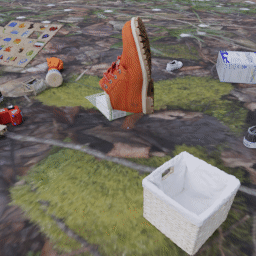
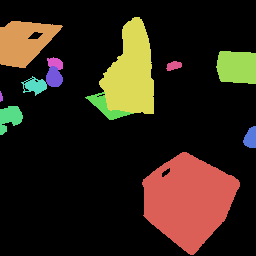
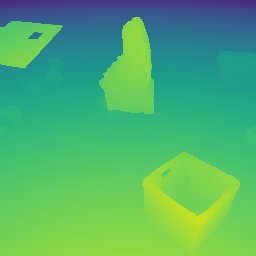
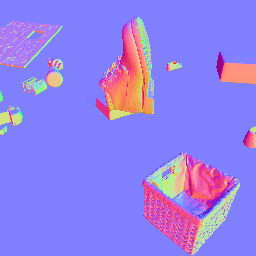
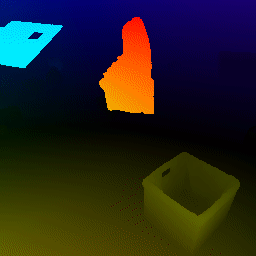
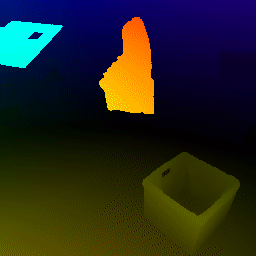
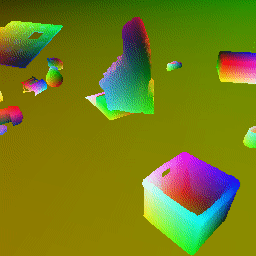
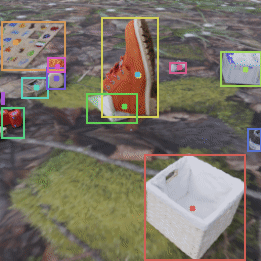

In [6]:
example = next(train_iter)
minv, maxv = example["metadata"]["forward_flow_range"]
forward_flow = example["forward_flow"] / 65535 * (maxv - minv) + minv

minv, maxv = example["metadata"]["backward_flow_range"]
backward_flow = example["backward_flow"] / 65535 * (maxv - minv) + minv

minv, maxv = example["metadata"]["depth_range"]
depth = example["depth"] / 65535 * (maxv - minv) + minv

media.show_videos({"rgb": example["video"], 
                   "segmentation": [segmentation_to_rgb(s, num_objects=example["metadata"]["num_instances"])
                                    for s in example["segmentations"]],
                   "depth": depth_to_rgb(example["depth"], sqrt=True),
                   "normal": example["normal"],
                   "forward_flow": flow_to_rgb(forward_flow, white_bg=False),
                   "backward_flow": flow_to_rgb(backward_flow, white_bg=False),
                   "object_coordinates": example["object_coordinates"], 
                   "bboxes/center_of_mass": plot_bboxes(example),
                   },
                fps=12,
                columns=4,
                codec="gif",
)
print_instance_ids(example, ds_info)

In [7]:
example.keys()

dict_keys(['background', 'backward_flow', 'camera', 'depth', 'events', 'forward_flow', 'instances', 'metadata', 'normal', 'object_coordinates', 'segmentations', 'video'])

In [28]:
#dict_keys(['angular_velocities', 'asset_id', 'bbox_frames', 'bboxes', 
# 'bboxes_3d', 'category', 'friction', 'image_positions', 
# 'is_dynamic', 'mass', 'positions', 'quaternions', 
# 'restitution', 'scale', 'velocities', 'visibility'])
example['instances']['category']

array([ 6, 16, 14,  6,  6, 16, 16, 12, 14, 16, 14,  6, 14])

In [18]:
seg_t = example["segmentations"][0]   #(24, 256, 256, 1)
num_objects = example["metadata"]["num_instances"]
# print(example["metadata"])
for k in range(num_objects):
    mask_k = (seg_t[..., 0] == k)     # 这一帧中，第 k 个物体的像素区域

    print(f"Object {k}: Number of pixels = {np.sum(mask_k)},mask shape = {mask_k.shape}")

inst = example["instances"]
print(inst['category'])

Object 0: Number of pixels = 50663,mask shape = (256, 256)
Object 1: Number of pixels = 6388,mask shape = (256, 256)
Object 2: Number of pixels = 1929,mask shape = (256, 256)
Object 3: Number of pixels = 3508,mask shape = (256, 256)
Object 4: Number of pixels = 1177,mask shape = (256, 256)
Object 5: Number of pixels = 424,mask shape = (256, 256)
Object 6: Number of pixels = 420,mask shape = (256, 256)
Object 7: Number of pixels = 276,mask shape = (256, 256)
Object 8: Number of pixels = 0,mask shape = (256, 256)
Object 9: Number of pixels = 214,mask shape = (256, 256)
Object 10: Number of pixels = 267,mask shape = (256, 256)
Object 11: Number of pixels = 24,mask shape = (256, 256)
Object 12: Number of pixels = 136,mask shape = (256, 256)
[ 6 16 14  6  6 16 16 12 14 16 14  6 14]


In [19]:
def get_object_caption(example, ds_info, k):
    inst = example["instances"]

    # 情况 1：MOVi-E / GSO 风格，直接有 asset_id，形如 "gso_1234"
    if "asset_id" in inst:
        return inst["asset_id"][k].decode("utf-8")

    # 情况 2：CLEVR 风格，用离散属性拼接
    labels = []
    if "size_label" in inst:
        size_idx = inst["size_label"][k]
        size = ds_info.features["instances"]["size_label"].names[size_idx]
        labels.append(size)

    if "color_label" in inst:
        color_idx = inst["color_label"][k]
        color = ds_info.features["instances"]["color_label"].names[color_idx]
        labels.append(color)

    material_idx = inst["material_label"][k]
    material = ds_info.features["instances"]["material_label"].names[material_idx]
    labels.append(material)

    shape_idx = inst["shape_label"][k]
    shape = ds_info.features["instances"]["shape_label"].names[shape_idx]
    labels.append(shape)

    # 拼成 "small red rubber cube"
    return " ".join(labels)


In [ ]:
ds_info = ds_info
num_objects = example["metadata"]["num_instances"]
for k in range(num_objects):
    cap = get_object_caption(example, ds_info, k)
    print(k, cap)

0 Target_Basket_Medium
1 ALPHABET_AZ_GRADIENT
2 Timberland_Womens_Waterproof_Nellie_Chukka_Double
3 Phillips_Caplets_Size_24
4 Dell_Ink_Cartridge_Yellow_31
5 FIRE_ENGINE
6 GARDEN_SWING
7 Razer_Abyssus_Ambidextrous_Gaming_Mouse
8 Womens_Bluefish_2Eye_Boat_Shoe_in_Linen_Oat
9 STACKING_RING
10 Womens_Betty_Chukka_Boot_in_Navy_aEE8OqvMII4
11 Android_Figure_Orange
12 Mens_Bahama_in_White_vSwvGMCo32f


num_objects: 13
visible_ids (filtered): [0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12]


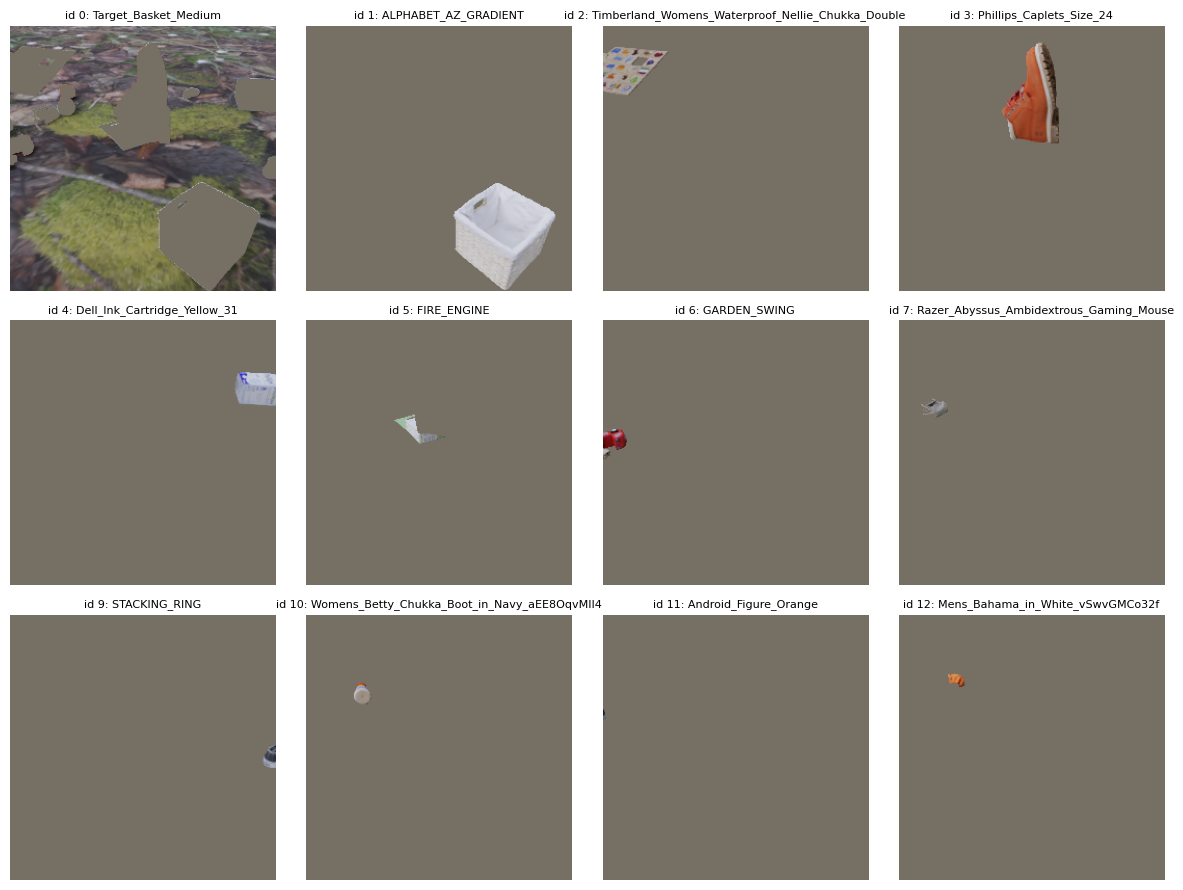

In [22]:
import numpy as np
import matplotlib.pyplot as plt

frame_idx = 0  # 想看的帧编号

img = example["video"][frame_idx]            # (H, W, 3)
seg = example["segmentations"][frame_idx]    # (H, W) or (H, W, 1)
if seg.ndim == 3:
    seg = seg[..., 0]

H, W = img.shape[:2]

# 数据里真实的物体个数（0 ~ num_objects-1）
num_objects = example["metadata"]["num_instances"]

# 这一帧的所有 label
visible_ids = np.unique(seg)
# 过滤掉负数 & 不在 [0, num_objects-1] 范围内的 id
visible_ids = [int(i) for i in visible_ids if 0 <= int(i) < num_objects]

print("num_objects:", num_objects)
print("visible_ids (filtered):", visible_ids)

n = len(visible_ids)
cols = int(np.ceil(np.sqrt(n)))
rows = int(np.ceil(n / cols))

fig, axes = plt.subplots(rows, cols, figsize=(3*cols, 3*rows))
axes = np.array(axes).reshape(-1)
for ax in axes:
    ax.axis("off")

for ax, obj_id in zip(axes, visible_ids):
    # 1) mask
    mask = (seg == obj_id)

    # 2) 用 mask 抠图
    img_float = img.astype(np.float32)
    bg_color = img_float.mean(axis=(0, 1), keepdims=True)
    masked_img = np.where(mask[..., None], img_float, bg_color)

    if img_float.max() > 1.5:
        masked_img = np.clip(masked_img, 0, 255).astype(np.uint8)
    else:
        masked_img = np.clip(masked_img, 0, 1.0)

    # 3) caption（这里不会再越界）
    caption = get_object_caption(example, ds_info, obj_id)

    # 4) 画图
    ax.imshow(masked_img)
    ax.set_title(f"id {obj_id}: {caption}", fontsize=8)
    ax.axis("off")

plt.tight_layout()
plt.show()
